<a href="https://colab.research.google.com/github/taralgrg/blister_train/blob/master/blister_train_MobileNetV2_Final1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.mobilenet_v2 import preprocess_input, decode_predictions


Using TensorFlow backend.



# **Recognize tactile pavement using Transfer Learning**

In [2]:
tf.__version__

'2.0.0-dev20190826'

In [0]:
#@title Setup Input Pipeline


Accessing 2 classes of image data from google drive.

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


Use ImageDataGenerator to rescale the images.

Create the train generator and specify where the train dataset directory, image size, batch size.

Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/content/gdrive/My Drive/blister_images/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    '/content/gdrive/My Drive/blister_images/',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 1204 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## Create the base model from the pre-trained convnets

Create the base model from the MobileNet V2 model and pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images.

First, pick which intermediate layer of MobileNet V2 will be used for feature extraction. A common practice is to use the output of the very last layer before the flatten operation, the so-called "bottleneck layer". The reasoning here is that the following fully-connected layers will be too specialized to the task the network was trained on, and thus the features learned by these layers won't be very useful for a new task. The bottleneck features, however, retain much generality.


In [5]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')


9412608/9406464 [==============================] - 2s 0us/step


## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [0]:
base_model.trainable = False

### Add a classification head

In [0]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
#   tf.keras.layers.Dense(256, activation='relu'),
#   tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2), 
#   tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

### Compile the model


In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0002), 
              loss=tf.keras.losses.mean_absolute_error, 
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 2,430,338
Trainable params: 172,354
Non-trainable params: 2,257,984
________________________________________

### Train the model

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [11]:
epochs = 10

history = model.fit_generator(train_generator, 
                    epochs=epochs, 
                    validation_data=val_generator)

Epoch 1/10
19/19 [==============================] - 269s 14s/step - loss: 0.1303 - accuracy: 0.9643 - val_loss: 0.1289 - val_accuracy: 1.0000
Epoch 2/10
19/19 [==============================] - 17s 914ms/step - loss: 0.0463 - accuracy: 0.9875 - val_loss: 0.0804 - val_accuracy: 1.0000
Epoch 3/10
19/19 [==============================] - 22s 1s/step - loss: 0.0254 - accuracy: 0.9892 - val_loss: 0.0710 - val_accuracy: 1.0000
Epoch 4/10
19/19 [==============================] - 22s 1s/step - loss: 0.0205 - accuracy: 0.9934 - val_loss: 0.0673 - val_accuracy: 1.0000
Epoch 5/10
19/19 [==============================] - 22s 1s/step - loss: 0.0088 - accuracy: 0.9992 - val_loss: 0.0671 - val_accuracy: 0.9933
Epoch 6/10
19/19 [==============================] - 22s 1s/step - loss: 0.0119 - accuracy: 0.9958 - val_loss: 0.0952 - val_accuracy: 0.9333
Epoch 7/10
19/19 [==============================] - 22s 1s/step - loss: 0.0091 - accuracy: 0.9958 - val_loss: 0.0300 - val_accuracy: 1.0000
Epoch 8/10
19/1

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor. 

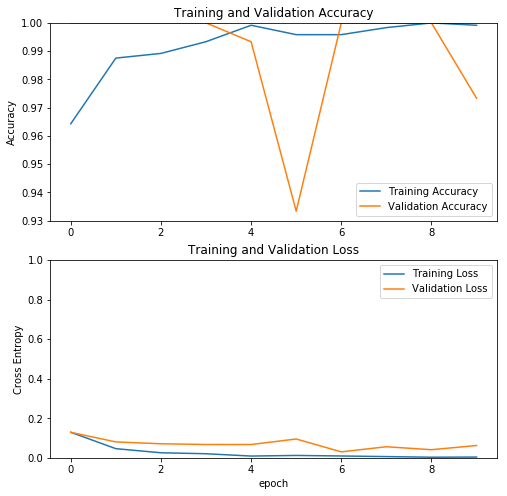

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model2.tflite', 'wb') as f:
  f.write(tflite_model)  

W0821 16:41:59.217997 140372317714304 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[[0.3691647 0.6308353]]


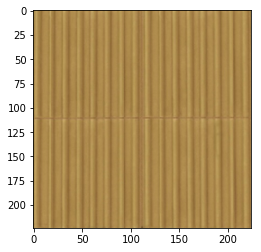

In [33]:
import cv2

CATEGORIES = ["blister", "corduroy"]

def prepare (filepath):
  img_array = cv2.imread(filepath)
  new_array = cv2.resize(img_array,(IMAGE_SIZE,IMAGE_SIZE))
  plt.imshow(new_array)
  new_array=new_array.astype('float16')
  return new_array.reshape(-1, IMAGE_SIZE, IMAGE_SIZE,3)

prediction = model.predict([prepare('/content/gdrive/My Drive/blister_images/corduroy/average3.jpg')])
print(prediction)
# print(CATEGORIES[int(prediction[0][0])])
